<a href="https://colab.research.google.com/github/buthaina279/P4DS/blob/main/COMP5623M_CW1_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COMP5623M Assessment Coursework 1 - Image Classification [100 marks]

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this coursework, you will:

> 1. Practice building, evaluating, and finetuning a convolutional neural network on an image dataset from development to testing. 
> 2. Gain a deeper understanding of feature maps and filters by visualizing some from a pre-trained network. 


### Setup and resources 

You must work using this provided template notebook.

Having a GPU will speed up the training process, especially for Question 1.3. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the ImageNet dataset [https://image-net.org/]. Our subset of Tiny ImageNet contains 30 different categories, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Private class Kaggle competition and data](https://www.kaggle.com/t/9b703e0d71824a658e186d5f69960e27)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard.

### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis"

Final note:

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):


ml20baya

Your full name:

Buthaina Abdullah Alshareef

## Imports

Feel free to add to this section as needed.

You may need to download `cv2` using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [39]:
import cv2
import math

import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url

# Imports
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms,utils
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
import torchvision
import torch.nn.functional as F
from tqdm import tqdm

## QUESTION 1 [55 marks]

One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**
*   **1.1.1** PyTorch ```Dataset``` and ```DataLoader``` classes
*   **1.1.2** PyTorch ```Model``` class for simple CNN model
*   **1.1.3** Overfitting on a single batch
*   **1.2.1** Training on complete dataset
*   **1.2.2** Fine-tuning model
*   **1.2.3** Generating confusion matrices
*   **1.3**   Testing on test set on Kaggle


## 1.1 Single-batch training [14 marks]

We will use a method of development called “single-batch training”, or "overfitting a single batch", in which we check that our model and the training code is working properly and can overfit a single training batch (i.e., we can drive the training loss to zero). Then we move on to training on the complete training set and adjust for any overfitting and fine-tune the model via regularisation.

### 1.1.1 Dataset class [3 marks]

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [4]:
print(torch.cuda.device_count())

1


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
ROOT_DIR = "/content/drive/MyDrive/comp5623m-2022/train_set/train_set/"
ROOT = "/content/drive/MyDrive/comp5623m-2022/"


In [ ]:
#!unzip "/content/drive/MyDrive/comp5623m-2022_z.zip" -d "/content"

In [6]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CLASS_LABELS = ["baboon",
                "banana"
                ,"bee"
                ,"bison"
                ,"butterfly"
                ,"candle"
                ,"cardigan"
                ,"chihuahua"
                ,"elephant"
                ,"espresso"
                ,"fly"
                ,"goldfish"
                ,"goose"
                ,"grasshopper"
                ,"hourglass"
                ,"icecream"
                ,"ipod"
                ,"jellyfish"
                ,"koala"
                ,"ladybug"
                ,"lion"
                ,"mushroom"
                ,"penguin"
                ,"pig"
                ,"pizza"
                ,"pretzel"
                ,"redpanda"
                ,"refrigerator"
                ,"sombrero"
                ,"umbrella"]



mean =  [0.4828, 0.4419, 0.3691]
std = [0.2130, 0.2060, 0.2022]

class TinyImageNet30(Dataset):
    def __init__(self, df, transform = None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_x = Image.open(self.df['path'][index])
        
        try:
            img_x = img_x.convert('RGB')
            
        except:
            pass
        
        img_y = torch.tensor(int(self.df['class'][index]))
        
        if self.transform:
            img_x = self.transform(img_x)
        return img_x,img_y
        

paths, classes = [], []
for i, dir_ in enumerate(CLASS_LABELS):
    for entry in os.scandir(ROOT_DIR + dir_):
        if (entry.is_file()):
            paths.append(entry.path)
            classes.append(i)
            
data = {'path': paths,'class': classes}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True)


print("Found", len(data_df), "images.")
print(data_df.head())

trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Split the data into train and test sets
train_split = 0.80 
train_size = int(len(data_df)*train_split)


train_dataset = TinyImageNet30(
    df=data_df[:train_size],
    transform=trnsfrm,
)

valid_dataset = TinyImageNet30(
    df=data_df[train_size:].reset_index(drop=True),
    transform=trnsfrm,
)

train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True,num_workers=6)

valid_loader = DataLoader(valid_dataset, batch_size=64,shuffle=True,num_workers=6)


print("dataset_train length", len(train_dataset))
print("dataset_valid length", len(valid_dataset))
print("train_loader length", len(train_loader))
print("valid_loader length", len(valid_loader))



Found 13500 images.
                                                path  class
0  /content/drive/MyDrive/comp5623m-2022/train_se...      3
1  /content/drive/MyDrive/comp5623m-2022/train_se...     11
2  /content/drive/MyDrive/comp5623m-2022/train_se...     18
3  /content/drive/MyDrive/comp5623m-2022/train_se...     28
4  /content/drive/MyDrive/comp5623m-2022/train_se...     12
dataset_train length 10800
dataset_valid length 2700
train_loader length 169
valid_loader length 43


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 64, 64])


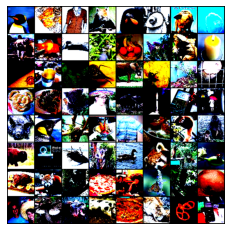

22 25 6 26 22 28 23 17 23 11 1 2 1 4 10 5 19 15 19 2 8 2 18 23 25 24 18 28 8 5 16 29 23 22 18 15 6 15 26 0 3 16 10 18 12 26 26 19 15 26 26 24 28 4 26 15 28 21 20 23 24 20 25 16


In [ ]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.axis('off')
    plt.show()
    return xa
    
# single batch
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.size())

#disply images
timshow(utils.make_grid(images))
print(*labels.numpy())     # * unpack the ndarray

### 1.1.2 Define a CNN model [3 marks]

Create a new model class using a combination of convolutional and fully connected layers, ReLU, and max-pool. 

In [67]:
class model112(nn.Module):

  def __init__(self):


    super(model112, self).__init__()

    self.conv1 = nn.Conv2d(3, 87, kernel_size= 5, padding= 0)
    self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(87, 64, kernel_size= 3, padding= 0)
    self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
    self.fcl1 = nn.Linear(14*14*64, 1500)

    self.fcl2 = nn.Linear(1500, 30)
        
  def forward(self, x):


    x = F.relu(self.conv1(x))
    x = self.mp1(x)

    x = F.relu(self.conv2(x))
    x = self.mp2(x)

    x = x.reshape(-1, 14*14*64)

    x = self.fcl1(x)
    x = F.relu(x)

    x = self.fcl2(x)


    return x
#model122 = model112()
model112 = nn.DataParallel(model122())
model112 = model112.to(device)   

In [68]:
#model122 = model112()
model112 = nn.DataParallel(model122())
model112 = model112.to(device)

In [70]:
model112 = nn.DataParallel(model122)

In [71]:
model112 = model112.to(device)

In [72]:
model122

model112(
  (conv1): Conv2d(3, 87, kernel_size=(5, 5), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(87, 64, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fcl1): Linear(in_features=12544, out_features=1500, bias=True)
  (fcl2): Linear(in_features=1500, out_features=30, bias=True)
)

In [7]:
# define a Model class for single and complete 
net = nn.Sequential(
    nn.Conv2d(3, 87, kernel_size= 5, padding= 0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(87, 64, kernel_size= 3, padding= 0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    
    nn.Linear(14*14*64, 1500),
    nn.ReLU(),
    
    nn.Linear(1500, 30)
)

summary(net.to(device), input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 87, 60, 60]           6,612
              ReLU-2           [-1, 87, 60, 60]               0
         MaxPool2d-3           [-1, 87, 30, 30]               0
            Conv2d-4           [-1, 64, 28, 28]          50,176
              ReLU-5           [-1, 64, 28, 28]               0
         MaxPool2d-6           [-1, 64, 14, 14]               0
           Flatten-7                [-1, 12544]               0
            Linear-8                 [-1, 1500]      18,817,500
              ReLU-9                 [-1, 1500]               0
           Linear-10                   [-1, 30]          45,030
Total params: 18,919,318
Trainable params: 18,919,318
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 6.36
Params size (MB): 72.17
Esti

### 1.1.3 Single-batch training [8 marks]

Write the foundational code which trains your network given **one single batch** of training data and computes the loss on the complete validation set for each epoch. Set ```batch_size = 64```. 

Display the graph of the training and validation loss over training epochs, showing as long as necessary to show you can drive the training loss to zero.

> Please leave all graphs and code you would like to be marked clearly displayed without needing to run code cells or wait for training.


In [57]:
#validation for all models
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    # net = net.to(device)
    n = 0    # counter for number of minibatches
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = net(images)
            
            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            
    return running_loss/n, correct/total 

In [74]:
# instantiate your new Model class
# model_122
#callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
#model.set_callbacks(callbacks)
def run_model(epoch, resultPath, learningRate, train_loader, model):
  nepochs = epoch
  #results_path = ROOT
  results_path = ROOT+ resultPath
  statsrec = np.zeros((4,nepochs))
  loss_fn = nn.CrossEntropyLoss()

  optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum=0.9)
  #optimizer = optim.Adadelta(model_122a.parameters())
  #ADam

  for epoch in range(nepochs):  # loop over the dataset multiple times
      correct = 0          # number of examples predicted correctly (for accuracy)
      total = 0            # number of examples
      running_loss = 0.0   # accumulated loss (for mean loss)
      n = 0                # number of minibatches
      for data in tqdm(train_loader):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward, backward, and update parameters
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()
      
          # accumulate loss
          running_loss += loss.item()
          n += 1
          
          # accumulate data for accuracy
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)    # add in the number of labels in this minibatch
          correct += (predicted == labels).sum().item()  # add in the number of correct labels
      
      # collect together statistics for this epoch
      ltrn = running_loss/n
      atrn = correct/total 
      ltst, atst = stats(valid_loader, model)
      statsrec[:,epoch] = (ltrn, atrn, ltst.cpu(), atst)
      print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  validation loss: {ltst.cpu(): .3f} validation accuracy: {atst: .1%}")

      # save network parameters, losses and accuracy
  torch.save({"state_dict": model.state_dict(), "stats": statsrec}, results_path)

In [75]:
run_model(50,'results/singlebatch50epochsClass.pt',0.01, train_loader,model112)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [00:18<00:00,  9.33it/s]


NameError: ignored

In [ ]:
nepochs = 50
#results_path = ROOT
results_path = ROOT+'results/singlebatch50epochsClass.pt'

statsrec = np.zeros((4,nepochs))

data = next(iter(train_loader))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model112.parameters(), lr=0.01, momentum=0.9)

for epoch in range(nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    
    # get a batch of random training examples (images and corresponding labels)
    
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
        
         # Zero the parameter gradients
    optimizer.zero_grad()

        # Forward, backward, and update parameters
    outputs = model112(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    
        # accumulate loss
    running_loss += loss.item()
    n += 1
        
        # accumulate data for accuracy
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)    # add in the number of labels in this minibatch
    correct += (predicted == labels).sum().item()  # add in the number of correct labels
    
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(valid_loader, model112)
    statsrec[:,epoch] = (ltrn, atrn, ltst.cpu(), atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  validation loss: {ltst: .3f} validation accuracy: {atst: .1%}")

# save network parameters, losses and accuracy
torch.save({"state_dict": model112.state_dict(), "stats": statsrec}, results_path)

# save network parameters and losses
#torch.save({"state_dict": net.state_dict(), "losses": losses}, results_path)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 0 training loss:  2.184 training accuracy:  34.4%  validation loss:  2.214 validation accuracy:  35.6%
epoch: 1 training loss:  1.983 training accuracy:  39.1%  validation loss:  2.227 validation accuracy:  36.0%
epoch: 2 training loss:  1.714 training accuracy:  59.4%  validation loss:  2.272 validation accuracy:  34.4%
epoch: 3 training loss:  1.469 training accuracy:  60.9%  validation loss:  2.360 validation accuracy:  31.7%
epoch: 4 training loss:  1.234 training accuracy:  67.2%  validation loss:  2.479 validation accuracy:  30.5%
epoch: 5 training loss:  0.992 training accuracy:  75.0%  validation loss:  2.647 validation accuracy:  29.1%
epoch: 6 training loss:  0.771 training accuracy:  79.7%  validation loss:  2.851 validation accuracy:  27.7%
epoch: 7 training loss:  0.583 training accuracy:  87.5%  validation loss:  3.047 validation accuracy:  26.8%
epoch: 8 training loss:  0.429 training accuracy:  95.3%  validation loss:  3.262 validation accuracy:  25.9%
epoch: 9 t

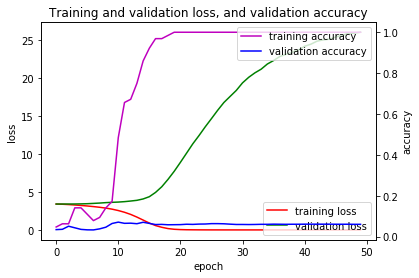

In [ ]:
results_path = ROOT+'results/singlebatch50epochs.pt'
data = torch.load(results_path)


statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'validation loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss, and validation accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'validation accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("roc.svg")
plt.show()



## 1.2 Training on complete dataset [23 marks]

### 1.2.1 Train CNN and show loss graph [6 marks]

Train your model on the complete training dataset, and use the validation set to determine when to stop training.

Display the graph of training and validation loss over epochs to show how you determined the optimal number of training epochs.

> As in previous sections, please leave the graph clearly displayed.


In [ ]:
# instantiate your new Model class
# model_122
#callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
#model.set_callbacks(callbacks)
def run_model(epoch, resultPath, learningRate, train_loader, model):
  nepochs = epoch
  #results_path = ROOT
  results_path = ROOT+ resultPath
  statsrec = np.zeros((4,nepochs))
  loss_fn = nn.CrossEntropyLoss()

  optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum=0.9)
  #optimizer = optim.Adadelta(model_122a.parameters())
  #ADam

  for epoch in range(nepochs):  # loop over the dataset multiple times
      correct = 0          # number of examples predicted correctly (for accuracy)
      total = 0            # number of examples
      running_loss = 0.0   # accumulated loss (for mean loss)
      n = 0                # number of minibatches
      for data in tqdm(train_loader):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          # Zero the parameter gradients
          optimizer.zero_grad()

          # Forward, backward, and update parameters
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()
      
          # accumulate loss
          running_loss += loss.item()
          n += 1
          
          # accumulate data for accuracy
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)    # add in the number of labels in this minibatch
          correct += (predicted == labels).sum().item()  # add in the number of correct labels
      
      # collect together statistics for this epoch
      ltrn = running_loss/n
      atrn = correct/total 
      ltst, atst = stats(valid_loader, model)
      statsrec[:,epoch] = (ltrn, atrn, ltst.cpu(), atst)
      print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  validation loss: {ltst.cpu(): .3f} validation accuracy: {atst: .1%}")

      # save network parameters, losses and accuracy
  torch.save({"state_dict": model.state_dict(), "stats": statsrec}, results_path)

In [ ]:
run_model(epoch, resultPath, learningRate, train_loader, model)

In [ ]:
nepochs = 50

#results_path = ROOT
results_path = ROOT+'results/completedataset50epochs.pt'

statsrec = np.zeros((4,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    for data in train_loader:
        inputs, labels = data
        
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
        
        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
    
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(valid_loader, net)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  validation loss: {ltst: .3f} validation accuracy: {atst: .1%}")

    

# save network parameters, losses and accuracy
torch.save({"state_dict": net.state_dict(), "stats": statsrec}, results_path)


epoch: 0 training loss:  2.887 training accuracy:  18.3%  validation loss:  2.688 validation accuracy:  24.0%
epoch: 1 training loss:  2.322 training accuracy:  32.5%  validation loss:  2.304 validation accuracy:  34.2%
epoch: 2 training loss:  1.917 training accuracy:  44.9%  validation loss:  2.213 validation accuracy:  37.7%
epoch: 3 training loss:  1.428 training accuracy:  57.7%  validation loss:  2.243 validation accuracy:  38.7%
epoch: 4 training loss:  0.816 training accuracy:  75.1%  validation loss:  2.655 validation accuracy:  35.3%
epoch: 5 training loss:  0.358 training accuracy:  89.0%  validation loss:  3.194 validation accuracy:  37.0%
epoch: 6 training loss:  0.167 training accuracy:  95.1%  validation loss:  3.589 validation accuracy:  37.0%
epoch: 7 training loss:  0.107 training accuracy:  97.0%  validation loss:  3.884 validation accuracy:  36.8%
epoch: 8 training loss:  0.081 training accuracy:  97.8%  validation loss:  3.657 validation accuracy:  40.7%
epoch: 9 t

In [ ]:
results_path = ROOT+'results/completedataset50epochs.pt'
data = torch.load(results_path)


statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'validation loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss, and validation accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'validation accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("roc.svg")
plt.show()


### 1.2.2 Finetuning [6 marks]

Now finetune your architecture by implementing at least 2 methods of reducing overfitting and increasing the model's ability to generalise. You are encouraged to further adjust the model after you have done the minimum requirement, to increase your model performance. Please do not use any pre-trained weights from a model trained on ImageNet.


**Method 1:** Data augmentation of your choice

**Method 2:** Adding dropout and/or batch normalisation to the model

If you adjust the Model class, redefine it below and instantiate it as ```model_122a```, ```model_122b```, and so on.



In [ ]:
# TO COMPLETE

In [ ]:
#method 1
trnsfrm_augmentation = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean, std)
])

trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [ ]:
train_dataset_fine = TinyImageNet30(
    df=data_df[:train_size],
    transform=trnsfrm_augmentation,
)

valid_dataset = TinyImageNet30(
    df=data_df[train_size:].reset_index(drop=True),
    transform=trnsfrm,
)

train_loader = DataLoader(train_dataset_fine, batch_size=64,shuffle=True,num_workers=6)

valid_loader = DataLoader(valid_dataset, batch_size=128,shuffle=True,num_workers=6)


print("len(dataset_train)", len(train_dataset))
print("len(dataset_valid)", len(valid_dataset))

print("len(train_loader)", len(train_loader))
print("len(valid_loader)", len(valid_loader))

len(dataset_train) 10800
len(dataset_valid) 2700
len(train_loader) 169
len(valid_loader) 22


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#yes 53%
model_122a = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 260, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(260),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(260, 320, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(320),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(320*8*8, 1500),
    nn.Dropout(0.5),
    nn.ReLU(),

    nn.Linear(1500, 700),
    nn.ReLU(),

    nn.Linear(700, 30)
)

summary(model_122a.to(device), input_size=(3, 64, 64))
model_122a = model_122a.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
         MaxPool2d-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 260, 32, 32]         299,780
       BatchNorm2d-6          [-1, 260, 32, 32]             520
              ReLU-7          [-1, 260, 32, 32]               0
         MaxPool2d-8          [-1, 260, 16, 16]               0
            Conv2d-9          [-1, 320, 16, 16]         749,120
      BatchNorm2d-10          [-1, 320, 16, 16]             640
             ReLU-11          [-1, 320, 16, 16]               0
        MaxPool2d-12            [-1, 320, 8, 8]               0
          Flatten-13                [-1, 20480]               0
           Linear-14                 [-

In [ ]:
#try 54%

#callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
#model.set_callbacks(callbacks)

model_122a = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 260, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(260),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(260, 320, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(320),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(320*8*8, 1500),
    nn.Dropout(0.5),
    nn.ReLU(),

    nn.Linear(1500, 700),
    nn.Dropout(0.2),
    nn.ReLU(),

    nn.Linear(700, 30)
)

summary(model_122a.to(device), input_size=(3, 64, 64))
model_122a = model_122a.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
         MaxPool2d-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 260, 32, 32]         299,780
       BatchNorm2d-6          [-1, 260, 32, 32]             520
              ReLU-7          [-1, 260, 32, 32]               0
         MaxPool2d-8          [-1, 260, 16, 16]               0
            Conv2d-9          [-1, 320, 16, 16]         749,120
      BatchNorm2d-10          [-1, 320, 16, 16]             640
             ReLU-11          [-1, 320, 16, 16]               0
        MaxPool2d-12            [-1, 320, 8, 8]               0
          Flatten-13                [-1, 20480]               0
           Linear-14                 [-

In [ ]:
#try2

#callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
#model.set_callbacks(callbacks)

model_122a = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 260, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(260),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(260, 320, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(320),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(320, 450, kernel_size= 3, padding= 1),
    nn.BatchNorm2d(450),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(450*4*4, 1500),
    nn.Dropout(0.5),
    nn.ReLU(),

    nn.Linear(1500, 700),
    nn.Dropout(0.2),
    nn.ReLU(),

    nn.Linear(700, 30)
)

summary(model_122a.to(device), input_size=(3, 64, 64))
model_122a = model_122a.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           3,584
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
         MaxPool2d-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 260, 32, 32]         299,780
       BatchNorm2d-6          [-1, 260, 32, 32]             520
              ReLU-7          [-1, 260, 32, 32]               0
         MaxPool2d-8          [-1, 260, 16, 16]               0
            Conv2d-9          [-1, 320, 16, 16]         749,120
      BatchNorm2d-10          [-1, 320, 16, 16]             640
             ReLU-11          [-1, 320, 16, 16]               0
        MaxPool2d-12            [-1, 320, 8, 8]               0
           Conv2d-13            [-1, 450, 8, 8]       1,296,450
      BatchNorm2d-14            [-1, 45

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
model_122a = model_122a.to(device)

In [ ]:
from tqdm import tqdm

In [ ]:
ROOT = "/content/drive/MyDrive/comp5623m-2022/"

In [ ]:
from tqdm import tqdm
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    # net = net.to(device)
    n = 0    # counter for number of minibatches
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = net(images)
            
            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            
    return running_loss/n, correct/total 

In [18]:
# instantiate your new Model class
# model_122
#callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
#model.set_callbacks(callbacks)

nepochs = 50
#results_path = ROOT
results_path = ROOT+'results/Finecompletedataset50epochsAdam.pt'
statsrec = np.zeros((4,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_122a.parameters(), lr=0.009, momentum=0.9)
#optimizer = optim.Adadelta(model_122a.parameters())
#ADam

for epoch in range(nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    for data in tqdm(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = model_122a(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
        
        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
    
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(valid_loader, model_122a)
    statsrec[:,epoch] = (ltrn, atrn, ltst.cpu(), atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  validation loss: {ltst.cpu(): .3f} validation accuracy: {atst: .1%}")

    # save network parameters, losses and accuracy
torch.save({"state_dict": model_122a.state_dict(), "stats": statsrec}, results_path)

  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 169/169 [00:43<00:00,  3.91it/s]


epoch: 0 training loss:  3.134 training accuracy:  11.5%  validation loss:  2.785 validation accuracy:  19.4%


100%|██████████| 169/169 [00:42<00:00,  3.94it/s]


epoch: 1 training loss:  2.749 training accuracy:  19.8%  validation loss:  2.629 validation accuracy:  25.1%


100%|██████████| 169/169 [00:42<00:00,  3.95it/s]


epoch: 2 training loss:  2.605 training accuracy:  23.8%  validation loss:  2.524 validation accuracy:  26.9%


100%|██████████| 169/169 [00:42<00:00,  4.01it/s]


epoch: 3 training loss:  2.496 training accuracy:  27.4%  validation loss:  2.369 validation accuracy:  31.6%


100%|██████████| 169/169 [00:42<00:00,  4.01it/s]


epoch: 4 training loss:  2.399 training accuracy:  29.9%  validation loss:  2.234 validation accuracy:  33.2%


100%|██████████| 169/169 [00:42<00:00,  4.02it/s]


epoch: 5 training loss:  2.310 training accuracy:  32.3%  validation loss:  2.212 validation accuracy:  35.3%


100%|██████████| 169/169 [00:42<00:00,  3.95it/s]


epoch: 6 training loss:  2.244 training accuracy:  34.0%  validation loss:  2.133 validation accuracy:  38.3%


100%|██████████| 169/169 [00:42<00:00,  4.00it/s]


epoch: 7 training loss:  2.170 training accuracy:  36.4%  validation loss:  2.039 validation accuracy:  40.8%


100%|██████████| 169/169 [00:42<00:00,  3.95it/s]


epoch: 8 training loss:  2.086 training accuracy:  38.4%  validation loss:  2.024 validation accuracy:  40.1%


100%|██████████| 169/169 [00:42<00:00,  3.95it/s]


epoch: 9 training loss:  2.033 training accuracy:  39.9%  validation loss:  1.923 validation accuracy:  44.0%


100%|██████████| 169/169 [00:42<00:00,  3.96it/s]


epoch: 10 training loss:  1.988 training accuracy:  41.3%  validation loss:  1.930 validation accuracy:  42.7%


100%|██████████| 169/169 [00:42<00:00,  3.95it/s]


epoch: 11 training loss:  1.919 training accuracy:  43.7%  validation loss:  1.950 validation accuracy:  43.0%


100%|██████████| 169/169 [00:42<00:00,  3.95it/s]


epoch: 12 training loss:  1.899 training accuracy:  43.8%  validation loss:  1.844 validation accuracy:  45.4%


100%|██████████| 169/169 [00:42<00:00,  3.98it/s]


epoch: 13 training loss:  1.858 training accuracy:  45.1%  validation loss:  1.848 validation accuracy:  45.6%


100%|██████████| 169/169 [00:42<00:00,  3.99it/s]


epoch: 14 training loss:  1.814 training accuracy:  46.3%  validation loss:  1.791 validation accuracy:  47.6%


100%|██████████| 169/169 [00:42<00:00,  3.98it/s]


epoch: 15 training loss:  1.772 training accuracy:  47.5%  validation loss:  1.792 validation accuracy:  47.6%


100%|██████████| 169/169 [00:42<00:00,  3.95it/s]


epoch: 16 training loss:  1.738 training accuracy:  48.5%  validation loss:  1.789 validation accuracy:  49.0%


100%|██████████| 169/169 [00:42<00:00,  3.97it/s]


epoch: 17 training loss:  1.698 training accuracy:  49.7%  validation loss:  1.785 validation accuracy:  49.8%


100%|██████████| 169/169 [00:42<00:00,  3.95it/s]


epoch: 18 training loss:  1.684 training accuracy:  50.2%  validation loss:  1.699 validation accuracy:  51.1%


100%|██████████| 169/169 [00:42<00:00,  3.94it/s]


epoch: 19 training loss:  1.638 training accuracy:  51.2%  validation loss:  1.758 validation accuracy:  49.6%


100%|██████████| 169/169 [00:42<00:00,  4.00it/s]


epoch: 20 training loss:  1.587 training accuracy:  52.2%  validation loss:  1.682 validation accuracy:  51.8%


100%|██████████| 169/169 [00:42<00:00,  3.95it/s]


epoch: 21 training loss:  1.576 training accuracy:  52.8%  validation loss:  1.709 validation accuracy:  51.1%


100%|██████████| 169/169 [00:43<00:00,  3.93it/s]


epoch: 22 training loss:  1.555 training accuracy:  53.2%  validation loss:  1.726 validation accuracy:  51.6%


100%|██████████| 169/169 [00:42<00:00,  3.95it/s]


epoch: 23 training loss:  1.524 training accuracy:  54.2%  validation loss:  1.682 validation accuracy:  51.2%


100%|██████████| 169/169 [00:42<00:00,  3.98it/s]


epoch: 24 training loss:  1.499 training accuracy:  54.9%  validation loss:  1.622 validation accuracy:  53.7%


100%|██████████| 169/169 [00:42<00:00,  4.00it/s]


epoch: 25 training loss:  1.483 training accuracy:  55.6%  validation loss:  1.663 validation accuracy:  52.4%


100%|██████████| 169/169 [00:42<00:00,  3.96it/s]


epoch: 26 training loss:  1.441 training accuracy:  56.5%  validation loss:  1.642 validation accuracy:  54.6%


100%|██████████| 169/169 [00:42<00:00,  3.96it/s]


epoch: 27 training loss:  1.409 training accuracy:  57.8%  validation loss:  1.611 validation accuracy:  53.5%


100%|██████████| 169/169 [00:42<00:00,  4.01it/s]


epoch: 28 training loss:  1.393 training accuracy:  58.0%  validation loss:  1.597 validation accuracy:  54.3%


100%|██████████| 169/169 [00:42<00:00,  3.93it/s]


epoch: 29 training loss:  1.379 training accuracy:  58.8%  validation loss:  1.574 validation accuracy:  55.6%


100%|██████████| 169/169 [00:42<00:00,  3.95it/s]


epoch: 30 training loss:  1.336 training accuracy:  59.9%  validation loss:  1.677 validation accuracy:  52.8%


100%|██████████| 169/169 [00:42<00:00,  3.98it/s]


epoch: 31 training loss:  1.340 training accuracy:  59.4%  validation loss:  1.597 validation accuracy:  54.2%


100%|██████████| 169/169 [00:42<00:00,  4.01it/s]


epoch: 32 training loss:  1.302 training accuracy:  60.5%  validation loss:  1.640 validation accuracy:  54.3%


100%|██████████| 169/169 [00:40<00:00,  4.17it/s]


epoch: 33 training loss:  1.301 training accuracy:  60.1%  validation loss:  1.609 validation accuracy:  55.2%


100%|██████████| 169/169 [00:40<00:00,  4.19it/s]


epoch: 34 training loss:  1.262 training accuracy:  61.7%  validation loss:  1.575 validation accuracy:  55.6%


100%|██████████| 169/169 [00:40<00:00,  4.21it/s]


epoch: 35 training loss:  1.236 training accuracy:  61.8%  validation loss:  1.576 validation accuracy:  56.5%


100%|██████████| 169/169 [00:39<00:00,  4.23it/s]


epoch: 36 training loss:  1.216 training accuracy:  63.0%  validation loss:  1.586 validation accuracy:  56.2%


100%|██████████| 169/169 [00:40<00:00,  4.21it/s]


epoch: 37 training loss:  1.202 training accuracy:  62.7%  validation loss:  1.623 validation accuracy:  55.3%


100%|██████████| 169/169 [00:39<00:00,  4.28it/s]


epoch: 38 training loss:  1.185 training accuracy:  63.4%  validation loss:  1.570 validation accuracy:  56.7%


100%|██████████| 169/169 [00:39<00:00,  4.29it/s]


epoch: 39 training loss:  1.148 training accuracy:  64.6%  validation loss:  1.551 validation accuracy:  57.0%


100%|██████████| 169/169 [00:39<00:00,  4.27it/s]


epoch: 40 training loss:  1.142 training accuracy:  64.8%  validation loss:  1.606 validation accuracy:  56.1%


100%|██████████| 169/169 [00:39<00:00,  4.25it/s]


epoch: 41 training loss:  1.116 training accuracy:  65.4%  validation loss:  1.555 validation accuracy:  56.5%


100%|██████████| 169/169 [00:39<00:00,  4.25it/s]


epoch: 42 training loss:  1.113 training accuracy:  65.7%  validation loss:  1.587 validation accuracy:  57.9%


100%|██████████| 169/169 [00:39<00:00,  4.26it/s]


epoch: 43 training loss:  1.073 training accuracy:  66.8%  validation loss:  1.520 validation accuracy:  58.3%


100%|██████████| 169/169 [00:39<00:00,  4.28it/s]


epoch: 44 training loss:  1.055 training accuracy:  67.1%  validation loss:  1.495 validation accuracy:  58.7%


100%|██████████| 169/169 [00:39<00:00,  4.28it/s]


epoch: 45 training loss:  1.055 training accuracy:  67.1%  validation loss:  1.524 validation accuracy:  58.4%


100%|██████████| 169/169 [00:39<00:00,  4.27it/s]


epoch: 46 training loss:  1.027 training accuracy:  67.8%  validation loss:  1.644 validation accuracy:  57.3%


100%|██████████| 169/169 [00:39<00:00,  4.25it/s]


epoch: 47 training loss:  1.008 training accuracy:  68.5%  validation loss:  1.503 validation accuracy:  58.0%


100%|██████████| 169/169 [00:39<00:00,  4.25it/s]


epoch: 48 training loss:  1.007 training accuracy:  68.6%  validation loss:  1.567 validation accuracy:  58.2%


100%|██████████| 169/169 [00:39<00:00,  4.25it/s]


epoch: 49 training loss:  0.966 training accuracy:  70.1%  validation loss:  1.590 validation accuracy:  57.4%


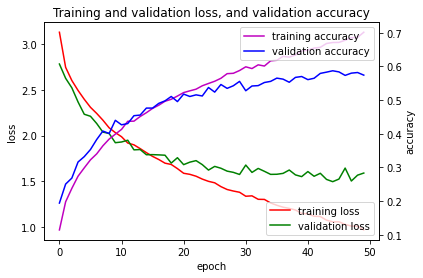

In [20]:
results_path = ROOT+'results/Finecompletedataset50epochsAdam.pt'
data = torch.load(results_path)


statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'validation loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss, and validation accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'validation accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("roc.svg")
plt.show()


### 1.2.3 Training comparison [4 marks]

Display, side-by-side or on one single graph, the training and validation loss graphs for the single-batch training (section 1.1.3), on the full training set (1.2.1) and your final fine-tuned model (1.2.2). 

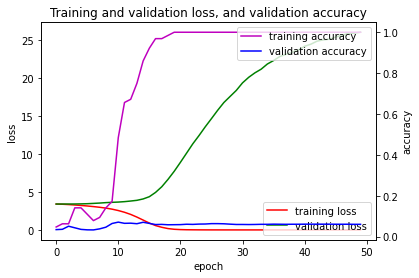

In [ ]:
#single batch
#single batch

results_path = ROOT+'results/singlebatch50epochs.pt'
data = torch.load(results_path)


statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'validation loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss, and validation accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'validation accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("roc.svg")
plt.show()



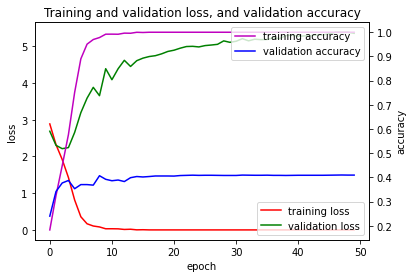

In [ ]:
#full training 

#full training 
results_path = ROOT+'results/completedataset50epochs.pt'
data = torch.load(results_path)


statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'validation loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss, and validation accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'validation accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("roc.svg")
plt.show()

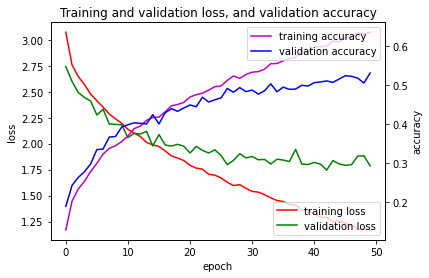

In [ ]:
#fine-tuned
results_path = ROOT+'results/Finecompletedataset50epochs700.pt'
data = torch.load(results_path)


statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'validation loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss, and validation accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'validation accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("roc.svg")
plt.show()


Explain what can be seen in the graphs.

--> Double click here to respond


### 1.2.4 Confusion matrices [7 marks]

Use your architecture with best accuracy to generate two confusion matrices, one for the training set and one for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.



In [ ]:
def accuracy(cnfm):
    return cnfm.trace()/cnfm.sum((0,1))

def recalls(cnfm):
    return np.diag(cnfm)/cnfm.sum(1)

def precisions(cnfm):
    return np.diag(cnfm)/cnfm.sum(0)  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Confusion matrix
[[154   0   0  22   1   4   4   8  32   0   2   1   8   2   2   1   2   1
   18   0  37   3   3  31   0   2   7   1   2   0]
 [  3 177  10   2   2  21   4   8   0   2   2  11   1   6  11  10   8   2
    3   8   1   6   2   0   2  19   2   3  13  10]
 [  4   3 185   3   6   3   2  10   2   0  59   6   2   9   1   6   1   3
    4  12   2   9   0   1   0   5   7   0   8   3]
 [  9   0   0 304   0   1   7   0  20   0   0   0   0   0   0   1   0   2
    4   1   4   0   0   8   0   0   4   0   1   9]
 [  0   0  15   1 308   1   0   1   0   0   6   1   0  11   0   2   2   0
    1   1   0   4   1   0   0   2   2   0   2   6]
 [  0  12   3   1   1 225   6   9   1   3   0   6   2   5   9  17   8   2
    0   3   4   2   1   2   0  16   2   2  10  10]
 [  1   0   3   3   1   4 266   2   8   0   0   1   2   2   4   3   3   6
    5   1   7   2   6   9   3   2   2   4   8   4]
 [  4   2   7   4   0  13   2 181   1   2   2   2   4   5   3  20   4   4
   12   2  23   6   6  11   1   9 

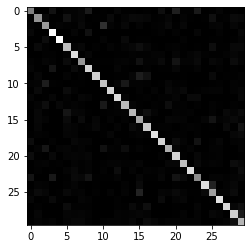

In [ ]:
# TO COMPLETE

nclasses = 30
cnfm = np.zeros((nclasses,nclasses),dtype=int)

# work without gradient computation since we are testing (i.e. no optimisation)
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_122a(images)
        
        # find the class with the highest output.
        # note that the outputs are confidence values since we didn't need to apply softmax in our network
        # (nn.crossentropyloss takes raw condifence values and does its own softmax)   
        _, predicted = torch.max(outputs, 1)    
       
        
        # accumulate into confusion matrix
        for i in range(labels.size(0)):
            cnfm[labels[i].item(),predicted[i].item()] += 1
              
print("Confusion matrix")
print(cnfm)

# show confusion matrix as a grey-level image
plt.imshow(cnfm, cmap='gray')

# show per-class recall and precision
print(f"Accuracy: {accuracy(cnfm) :.1%}")
r = recalls(cnfm)
p = precisions(cnfm)
for i in range(nclasses):
    print(f"Class {classes[i]} : Precision {p[i] :.1%}  Recall {r[i] :.1%}")




In [ ]:
#confusion matrix for validation set


# initialise confusion matrix
nclasses = classes.shape[0]
cnfm = np.zeros((nclasses,nclasses),dtype=int)

# work without gradient computation since we are testing (i.e. no optimisation)
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        
        # find the class with the highest output.
        # note that the outputs are confidence values since we didn't need to apply softmax in our network
        # (nn.crossentropyloss takes raw condifence values and does its own softmax)   
        _, predicted = torch.max(outputs, 1)    
       
        
        # accumulate into confusion matrix
        for i in range(labels.size(0)):
            cnfm[labels[i].item(),predicted[i].item()] += 1
              
print("Confusion matrix")
print(cnfm)

# show confusion matrix as a grey-level image
plt.imshow(cnfm, cmap='gray')

# show per-class recall and precision
print(f"Accuracy: {accuracy(cnfm) :.1%}")
r = recalls(cnfm)
p = precisions(cnfm)
for i in range(nclasses):
    print(f"Class {classes[i]} : Precision {p[i] :.1%}  Recall {r[i] :.1%}")




What conclusions can be drawn from the confusion matrices?

---> Double click to respond here



## 1.3 Testing on test data [18 marks]

### 1.3.1 Dataset and generating predictions [6 marks]

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. 


In [21]:
test_dir = ROOT + "test_set/test_set"
img_paths= []
img_name= []

for entry in os.scandir(test_dir):
    if (entry.is_file()):
        img_paths.append(entry.path)
        img_name.append(entry.name)
            
data = {'path': img_paths,'class': 0}

data_df = pd.DataFrame(data, columns=['path','class'])

# See what the dataframe now contains
print("Found", len(data_df), "images.")
# If you want to see the image meta data
print(data_df.head())

transfrm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
test_dataset = TinyImageNet30(
    df=data_df,
    transform=transfrm,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

Found 1500 images.
                                                path  class
0  /content/drive/MyDrive/comp5623m-2022/test_set...      0
1  /content/drive/MyDrive/comp5623m-2022/test_set...      0
2  /content/drive/MyDrive/comp5623m-2022/test_set...      0
3  /content/drive/MyDrive/comp5623m-2022/test_set...      0
4  /content/drive/MyDrive/comp5623m-2022/test_set...      0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 64, 64])


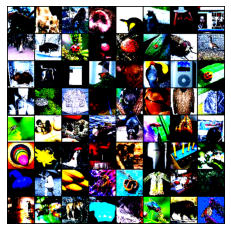

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [22]:

dataiter = iter(test_loader)
images, labels = dataiter.next()

print(images.size())

timshow(utils.make_grid(images))
print(*labels.numpy())  




In [23]:
predicted_class = []
for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward, backward, and update parameters
        outputs = model_122a(inputs)
        
        # the predicted lables / classes
        _, predicted = torch.max(outputs.data, 1)
        #add the predicted lables to the list
        predicted_class.extend(predicted.tolist()) 


### 1.3.2 CSV file and test set accuracy [12 marks]

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image on test set and 1 row for the headers.

> You may submit multiple times. We will use your personal top entry for allocating marks for this [10 marks]. The class leaderboard will not affect marking (brownie points!).



In [ ]:
# TO COMPLETE

In [24]:
data = {'ID': img_name,'Category': predicted_class}

In [25]:
test_df =pd.DataFrame(data,columns=['ID','Category'])

print("test length", len(data_df))
test_df.head()

test length 1500


,ID,Category
0,7f19ba4a_9471.JPEG,26
1,ff1e4f2b_5114.JPEG,0
2,b31f291a_7c51.JPEG,10
3,bb79ae30_cb47.JPEG,20
4,76978129_c38e.JPEG,22


In [26]:
test_df.to_csv("ml20baya.csv", index= False, header=True)

In [27]:
!cp ml20baya.csv "/content/drive/MyDrive/comp5623m-2022"



## QUESTION 2 [40 marks]



In this question, you will visualize the filters and feature maps of a fully-trained CNN (AlexNet) on the full ImageNet 2012 dataset.

> Please do not alter the name of the function or the number and type of its arguments and return values, otherwise the automatic grading function will not work correctly. You are welcome to import other modules (though the simplest solution only requires the ones below).


### **Overview:**
*   **2.1.1** Extract filters from model: ``fetch_filters(layer_idx, model)``
*   **2.2.1** Load test image
*   **2.2.2** Extract feature maps for given test image: ``fetch_feature_maps(image, model)``
*   **2.2.3** Display feature maps
*   **2.3.1** Generate Grad-CAM heatmaps: ``generate_heatmap(output, class_id, model, image)``
*   **2.3.2** Display heatmaps: add code to cell
*   **2.3.3** Generate heatmaps for failure analysis


### Loading a pre-trained model

Run the cell below to load an AlexNet model with pre-trained weights.

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

In [ ]:
model.features

In [ ]:
model.features[0]

In [ ]:
model.features[0].weight.shape


## 2.1 Extract and visualize the filters [6 marks]

In this section you will extract and visualize the filters from the pre-trained AlexNet.

### 2.1.1 Extract filters [4 marks]

Complete the following function ```fetch_filters``` to return all the filters from the convolutional layers at the given index in ```model.features``` (see printed model above for reference). 





> We will not test the behaviour of your function using invalid indices.



In [ ]:
def fetch_filters(layer_idx, model):
    """ 
        Args:
            layer_idx (int): the index of model.features specifying which conv layer
            model (AlexNet): PyTorch AlexNet object
        Return:
            filters (Tensor):      
    """
    filters = model.features[layer_idx].weight.detach()
    # TO COMPLETE
    return filters

In [ ]:
# all the indices of the conv layers
conv_layer_idx = [0, 3, 6, 8, 10]

filters = []

for layer_idx in conv_layer_idx:
    filters.append(fetch_filters(layer_idx, model))

For your testing purposes, the following code blocks test the dimensions of the function output.

In [ ]:
filters[0].shape

In [ ]:
assert list(filters[0].shape) == [64, 3, 11, 11]



### 2.1.2 Display filters [2 marks]

The following code will visualize some of the filters from each layer. Play around with viewing filters at different depths into the network. Note that ```filters[0]``` could be viewed in colour if you prefer, whereas the subsequent layers must be viewed one channel at a time in grayscale. 



In [ ]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(filters[0].numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt[0], cmap="gray")
    plt.axis('off')
plt.show()



## 2.2 Extract and visualize feature maps [10 marks]

In this section, you will pass a test image through the AlexNet and extract and visualize the resulting convolutional layer feature maps.

Complete the following code cell to load the test image ```man_bike.JPEG```.



### 2.2.1 Load test image [1 mark]


In [ ]:
# TO COMPLETE
from PIL import Image

im = Image.open('/Users/macbookpro/Desktop/Semester 2/AI/CW1/comp5623m-2022/man_bike.JPEG')

In [ ]:
im = im.convert('RGB')

Run the code cell below to apply the image transformation expected by the model.

In [ ]:
# ImageNet normalisation values, to apply to the image transform
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

im = data_transform(im)


### 2.2.2 Extract feature maps [5 marks]

Complete the function below to pass the test image through a single forward pass of the network. We are interested in the outputs of the max pool layers (outputs of conv layers at model.features indices 0, 3, and 10) for best visualization. Note that the input should pass through *every layer* of the model.

In [ ]:
def fetch_feature_maps(image, model):
    """
    Args:
        image (Tensor): a single input image with transform applied
        model (AlexNet): PyTorch AlexNet object
        
    Return:
        feature_maps (Tensor): all the feature maps from conv layers 
                    at indices 0, 3, and 10 (outputs of the MaxPool layers)
    """
    
    
    max_pool_layer = [2,5,12]
    
    # all the indices of the conv layers
    conv_layer_idx = [0, 3,10]

    #filters = []

    #for layer_idx in max_pool_layer:
    #    filters.append(fetch_filters(layer_idx, model))
    
    
    feature_maps = []
    model_length = len(model.features)
    for i in range(model_length):
        image = model.features[i].forward(image)
        # extract the feature map in the max pool layers
        if i in max_pool_layer:
            feature_map = image
            feature_maps.append(feature_map)

    # TO COMPLETE
    return feature_maps

In [ ]:
def fetch_feature_maps(image, model):   
    # pass the image through all the layers
    results = [conv_layers[0](image)]
    for i in range(1, len(conv_layers)):
        # pass the result from the last layer to the next layer
        if i in max_pool_layer:
            results.append(conv_layers[i](results[-1]))
    # make a copy of the `results`
    feature_maps = results
    return feature_maps

In [ ]:
feature_maps = fetch_feature_maps(im.unsqueeze(0), model)

In [ ]:
feature_maps[0][0].shape

For your testing purposes, the following code block tests the dimensions of part of the function output. Note that the first dimension is the batch size.

In [ ]:
assert len(feature_maps) == 3
assert list(feature_maps[0].shape) == [1, 64, 31, 31]



### 2.2.3 Display feature maps [4 marks]

Using the code for displaying filters as reference, write code in the block below to display the outputs of the first **16 feature maps from each of the 3 max-pool layers**.

In [ ]:
# TO COMPLETE

# limit how many filters to show
to_show = 16
max_pool_layer = [2,5,12]
# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))
for j, filt in enumerate(max_pool_layer):
    # plot the first channel of each filter in a grid
    for i, feature in enumerate(feature_maps[j].detach().numpy()[:to_show]):
        plt.subplot(plt_dim, plt_dim, i+1)
        plt.imshow(feature[0], cmap="gray")
        plt.axis('off')
    plt.show()

In [ ]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(feature_maps)):
    plt.figure(figsize=(30, 30))
    layer_viz = feature_map[num_layer][0, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 16: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(plt_dim, plt_dim, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")

In [ ]:
processed = []
for feature_map in feature_maps:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.numpy())
for fm in processed:
    print(fm.shape)

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    #a.set_title(names[i].split('(')[0], fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [ ]:
# TO COMPLETE

# limit how many filters to show
to_show = 16
max_pool_layer = [2,5,12]
# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))
for j, filt in enumerate(max_pool_layer):
    feature_test = feature_maps[j][0]
    # plot the first channel of each filter in a grid
    for i, feature in enumerate(feature_test.detach().numpy()[:to_show]):
        plt.subplot(plt_dim, plt_dim, i+1)
        plt.imshow(feature[0], cmap="gray")
        plt.axis('off')
    plt.show()

In [ ]:
for i, layer in enumerate(conv_layer_indices):
    #display the layer filter
    layer_filter = fetch_filter(layer, model)
    layer_feature_maps = feature_maps[i][0]

In [ ]:
for j, filt in enumerate(max_pool_layer):
    feature_test = feature_maps[j][0]
    print(j, "here",feature_test)




## 2.3 Understanding of filters and feature maps [7 marks]

Respond in detail to the questions below. (Note that all text boxes can be formatted using Markdown if desired).

### 2.3.1 [3 marks]
Describe what the three filters at indices 0, 4, and 6 from the first convolutional layer are detecting (reference the corresponding feature maps to support your discussion).


--> Double click here to respond

### 2.3.2 [2 marks]
Discuss how the filters change with depth into the network.

--> Double click here to respond

### 2.3.3 [2 marks]
Discuss how the feature maps change with depth into the network.

--> Double click here to respond


## 2.4 Gradient-weighted Class Activation Mapping (Grad-CAM) [17 marks]

In this section, we will explore using Gradient-weighted Class Activation Mapping (Grad-CAM) to generate coarse localization maps highlighting the important regions in the test images guiding the model's prediction. We will continue using the pre-trained AlexNet.

#### Preparation
>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.

#### The AlexNet class

>To implement Grad-CAM, we need to edit the AlexNet ```module``` class itself, so instead of loading the AlexNet model from ```torch.hub``` as we did above, we will use the official PyTorch AlexNet class code ([taken from here](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html)). In addition to the class definition, there is also a function below called ```alexnet()``` which allows you to specify whether you want the pretrained version or not, and if so, loads the weights. 

#### The hook

>[Hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) in PyTorch are functions which can be registered, or attached, to a ```Module``` or ```Tensor```. Hooks can be *forward* hooks or *backward* hooks; forward hooks are called with ```forward()``` and backward hooks with ```backward()```. In the model below, we register a forward hook that saves the **gradients of the activations** to the Tensor output of ```model.features```. The gradients are saved to a class variable so we can easily access them.

Carefully read the code block below. You do not need to add anything to the model.

In [ ]:
# defining where to load the pre-trained weights from
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth',
}

# the class definition
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        # a placeholder for storing the gradients
        self.gradients = None
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    # the hook for the gradients of the activations
    def activations_hook(self, grad):
        # stores the gradients of the hook's tensor to our placeholder variable
        self.gradients = grad

    # a method for extracting the activations of the last conv layer only (when we're 
    # not interested in a full forward pass)
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        x = self.features(x)
        
        # we register the hook here to save the gradients of the last convolutional
        # layer outputs
        hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs) -> AlexNet:
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [ ]:
model = alexnet(pretrained=True)

In [ ]:
# pass our test image through our new model with the hook
output = model(im.unsqueeze(0))

# save the predicted class
_, pred_cls = output.max(dim=1, keepdim=True)

Examine and understand the values stored in ```output``` and ```pred_cls```. What does AlexNet classify the test image as?

In [ ]:
output

In [ ]:
pred_cls

### 2.4.1 Generate Grad-CAM heatmaps [8 marks]

With the hooks in place, now implement the code to generate Grad-CAM heatmaps, by following the guiding comments in the code block below.

In [ ]:
def generate_heatmap(output, class_id, model, image):
    
    # 1. compute the gradient of the score for the predicted class (logit)
    # with respect to the feature map activations of the last convolutional layer
    # Hint: calling .backward() on a Tensor computes its gradients
    # TO COMPLETE
    
    # 2. get the gradients from the model placeholder variable
    # TO COMPLETE
    assert list(gradients.shape) == [1, 256, 7, 7]
    
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    assert list(pooled_gradients.shape) == [256]
    
    # 3. get the activations of the last convolutional layer
    # TO COMPLETE
    assert list(activations.shape) == [1, 256, 7, 7]
    
    # 4. weight (multiply) the channels (dim=1 of activations) by the corresponding
    # gradients (pooled_gradients)
    # TO COMPLETE

    # average the channels of the activations and squeeze out the extra dimension
    heatmap = torch.mean(activations, dim=1).squeeze()
    assert list(heatmap.shape) == [7, 7]
    
    # 5. apply a ReLU to the linear combination of maps because we are only 
    # interested in the features that have a positive influence on the class of 
    # interest, i.e. pixels whose intensity should be increased in order to increase y
    # Hint: you can use np.maximum() and torch.max() to perform ReLU if you prefer.
    
    # TO COMPLETE
    # return heatmap

In [ ]:
heatmap = generate_heatmap(output, pred_cls, model, im.unsqueeze(0))

Check the dimensions of ```heatmap```. Do they make sense?

### 2.4.2 Display heatmaps [4 marks]

Display ```heatmap``` as a coloured heatmap super-imposed onto the original image. To get results as shown in the paper, we recommend the following steps:

1. Resize the heatmap to match the size of the image.
2. Rescale the image to a 0-255 integer range.
3. Apply a colormap to the heatmap using ```cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)```.
4. Multiply all values of heatmap by 0.4 to reduce colour saturation.
5. Superimpose the heatmap onto the original image (Note: please perform cv2's addition - addition of two cv2 images, not numpy addition. See [here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html#:~:text=addWeighted()%20etc.-,Image%20Addition,OpenCV%20addition%20and%20Numpy%20addition.) for explanation.)
6. Normalize the image between 0-255 again.
7. Display the resulting image.

In [ ]:
# TO COMPLETE

Show the heatmap for class ```'seashore, coast, seacoast, sea-coast'``` (```class_id = 978```), super-imposed onto the original image.

In [ ]:
# TO COMPLETE

### 2.4.3 Failure analysis using Grad-CAM [5 marks]

Find an image (online, or from ImageNet or another dataset) which AlexNet classifies *incorrectly*. Display the image below, and show the model's predicted class. Then, generate the Grad-CAM heatmap and display it super-imposed onto the image.

In [ ]:
# TO COMPLETE

Briefly describe what explanation the Grad-CAM heatmap provides about why the model has failed to correctly classify your test image.

--> Double click to respond here

### 3 Overall quality [2 marks]

Marks awarded for overall degree of code readibility and omission of unnecessary messy outupts (for example, please avoid printed losses for every batch of a long training process, large numpy arrays, etc.) throughout the work.

**Please refer to the submission section at the top of this notebook to prepare your submission.**
